<a href="https://colab.research.google.com/github/gayecolakoglu/DiabeticRetinopathyDetection/blob/main/Bayesian_DenseNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pathlib
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [ ]:
#https://medium.com/@pierre.beaujuge/bayesian-optimization-on-the-head-classifier-of-pre-trained-cnns-using-the-cifar10-dataset-48c440b67b2c
# Install GPy, GPyOpt
!pip install tensorflow-addons
!pip install GPy==1.9.8
!pip install GPyOpt==1.2.1
import tensorflow as tf
import tensorflow.keras as K
import numpy as np
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline
import GPy
import GPyOpt
import tensorflow as tf
import tensorflow_addons as tfa
from GPyOpt.methods import BayesianOptimization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install split-folders
import splitfolders
splitfolders.ratio('/content/gdrive/MyDrive/allDataCLAHE', output="output", seed=1337, ratio=(.7, 0.2, 0.1)) #train,val,test

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Copying files: 6332 files [02:20, 32.49 files/s] 

In [ ]:
#https://stackoverflow.com/questions/55674648/how-to-load-local-dataset-x-y-using-keras-framework
!pip install image-dataset-loader
from image_dataset_loader import load

(x_train, y_train), (x_test, y_test) = load('/content/output/', ['train', 'val'])

In [ ]:
def preprocess_data(X, Y):
    """
    function that pre-processes the DR dataset as per
    densenet model requirements for input images
    labels are one-hot encoded
    """
    X = K.applications.densenet.preprocess_input(X)
    Y = K.utils.to_categorical(Y)
    return X, Y

In [ ]:
# preprocess the data using the application's preprocess_input method and convert the labels to one-hot encodings
x_train, y_train = preprocess_data(x_train, y_train)
x_test, y_test = preprocess_data(x_test, y_test)

In [ ]:
input_tensor = K.Input(shape=(32, 32, 3))
# resize images to the image size upon which the network was pre-trained
resized_images = K.layers.Lambda(lambda image: tf.image.resize(image, (224, 224)))(input_tensor)
base_model = K.applications.DenseNet201(include_top=False,
                                        weights='imagenet',
                                        input_tensor=resized_images,
                                        input_shape=(224, 224, 3),
                                        pooling='max',
                                        classes=5)
output = base_model.layers[-1].output
base_model = K.models.Model(inputs=input_tensor, outputs=output)

In [ ]:
# using the training data
train_datagen = K.preprocessing.image.ImageDataGenerator()# no data augmentation for train set we did that in seperate code for class 1,3 and 4
      
train_generator = train_datagen.flow(x_train,
                                     y_train,
                                     batch_size=32,
                                     shuffle=False)
features_train = base_model.predict(train_generator)

In [ ]:
# repeat the same operation with the test data (here used for validation)
val_datagen = K.preprocessing.image.ImageDataGenerator()  # no augmentation for validation set
val_generator = val_datagen.flow(x_test,
                                 y_test,
                                 batch_size=32,
                                 shuffle=False)
features_valid = base_model.predict(val_generator)

In [ ]:
def build_model(units=256, learning_rate=1e-4, l2=1e-2, activation=2, rate=0.5, batch=32, optim=1):
  """function that builds a model for the head classifier"""
  # weights are initialized as per the he et al. method
  initializer = K.initializers.he_normal()
  input_tensor = K.Input(shape=features_train.shape[1])
  activation_dict = {1: 'relu', 2: 'elu', 3: 'tanh'}
  optimizer_dict = {1: 'Adam', 2: 'SGD', 3: 'RMSprop'}
  layer = K.layers.Dense(units=units,
                         activation=activation_dict[activation],
                         kernel_initializer=initializer,
                        kernel_regularizer=K.regularizers.l2(l2=l2))
  output = layer(input_tensor)
  dropout = K.layers.Dropout(rate)
  output = dropout(output)
  softmax = K.layers.Dense(units=5,
                           activation='softmax',
                           kernel_initializer=initializer,
                        kernel_regularizer=K.regularizers.l2(l2=l2))
  output = softmax(output)
  model = K.models.Model(inputs=input_tensor, outputs=output)
  # compile the densely-connected head classifier (here, "model")
  if optim==1:
    model.compile(
            optimizer=K.optimizers.Adam(learning_rate=learning_rate),
            loss='categorical_crossentropy',
            metrics=["accuracy"])
  elif optim==2:
    model.compile(
            optimizer=K.optimizers.SGD(learning_rate=learning_rate),
            loss='categorical_crossentropy',
            metrics=["accuracy"])
  elif optim==3:
    model.compile(
            optimizer=K.optimizers.RMSprop(learning_rate=learning_rate),
            loss='categorical_crossentropy',
            metrics=["accuracy"])
  else:
    print("Wrong optimizer!!")
  # Define some callback functions to be used by the model during training
  # reduce learning rate when val_accuracy has stopped improving
  lr_reduce = K.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                            factor=0.6,
                                            patience=2,
                                            verbose=1,
                                            mode='max',
                                            min_lr=1e-7)
  # stop training when val_accuracy has stopped improving
  early_stop = K.callbacks.EarlyStopping(monitor='val_accuracy',
                                         patience=3,
                                         verbose=1,
                                         mode='max')
  # callback to save the Keras model and (best) weights obtained on an epoch basis
  checkpoint = K.callbacks.ModelCheckpoint('DR.h5',
                                           monitor='val_accuracy',
                                           verbose=1,
                                           save_weights_only=False,
                                           save_best_only=True,
                                           mode='max',
                                           save_freq='epoch')
  return model, lr_reduce, early_stop, checkpoint, batch

In [ ]:
def fit_model(model, lr_reduce, early_stop, checkpoint, batch):
  """function that trains the head classifier"""
  history = model.fit(features_train, y_train,
                      batch_size=batch,
                      epochs=100,
                      verbose=0,
                      callbacks=[lr_reduce, early_stop, checkpoint],
                      validation_data=(features_valid, y_test),
                      shuffle=True)
  return history

In [ ]:
def evaluate_model(model):
  """function that evaluates the head classifier"""
  evaluation = model.evaluate(features_valid, y_test)
  return evaluation


Hyperparameters: [[1.28e+02 1.00e-06 1.00e-03 2.00e+00 3.00e-01 2.56e+02 3.00e+00]]

Epoch 1: val_accuracy improved from -inf to 0.48649, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.48649

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.48649

Epoch 4: val_accuracy did not improve from 0.48649
Epoch 4: early stopping
2/2 [==============================] - 0s 7ms/step - loss: 2.5497 - accuracy: 0.4865

LOSS:	2.5497002601623535 	 ACCURACY:	0.4864864945411682
[2.5497002601623535, 0.4864864945411682]



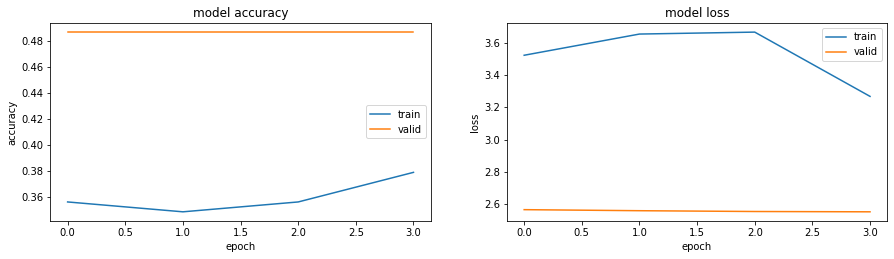


Hyperparameters: [[5.12e+02 1.00e-03 1.00e-02 1.00e+00 3.00e-01 1.28e+02 2.00e+00]]
2/2 [==============================] - 0s 7ms/step - loss: 2.5497 - accuracy: 0.4865

Epoch 1: val_accuracy improved from -inf to 0.37838, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.37838

Epoch 3: val_accuracy improved from 0.37838 to 0.43243, saving model to DR.h5

Epoch 4: val_accuracy did not improve from 0.43243

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 5: val_accuracy did not improve from 0.43243

Epoch 6: val_accuracy did not improve from 0.43243
Epoch 6: early stopping
2/2 [==============================] - 0s 7ms/step - loss: 13.2584 - accuracy: 0.4324

LOSS:	13.258406639099121 	 ACCURACY:	0.4324324429035187
[13.258406639099121, 0.4324324429035187]



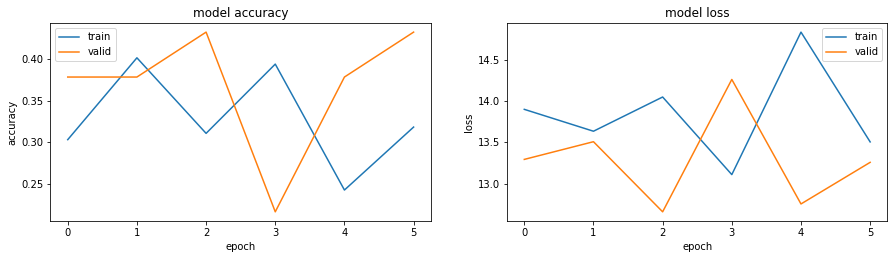


Hyperparameters: [[5.12e+02 1.00e-06 1.00e-02 2.00e+00 3.00e-01 3.20e+01 1.00e+00]]
2/2 [==============================] - 0s 12ms/step - loss: 2.5497 - accuracy: 0.4865

Epoch 1: val_accuracy improved from -inf to 0.10811, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.10811

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.10811

Epoch 4: val_accuracy did not improve from 0.10811
Epoch 4: early stopping
2/2 [==============================] - 0s 7ms/step - loss: 13.2703 - accuracy: 0.1081

LOSS:	13.270286560058594 	 ACCURACY:	0.10810811072587967
[13.270286560058594, 0.10810811072587967]



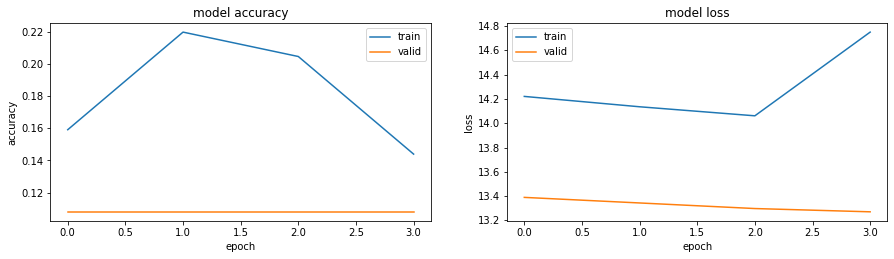


Hyperparameters: [[2.56e+02 1.00e-04 1.00e-01 1.00e+00 3.00e-01 2.56e+02 1.00e+00]]
2/2 [==============================] - 0s 9ms/step - loss: 2.5497 - accuracy: 0.4865

Epoch 1: val_accuracy improved from -inf to 0.18919, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.18919 to 0.24324, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.24324 to 0.32432, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.32432 to 0.43243, saving model to DR.h5

Epoch 5: val_accuracy did not improve from 0.43243

Epoch 6: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 6: val_accuracy did not improve from 0.43243

Epoch 7: val_accuracy improved from 0.43243 to 0.45946, saving model to DR.h5

Epoch 8: val_accuracy did not improve from 0.45946

Epoch 9: ReduceLROnPlateau reducing learning rate to 3.599999909056351e-05.

Epoch 9: val_accuracy did not improve from 0.45946

Epoch 10: val_accuracy did not improve from 0.45946
Epoch 10: early stoppin

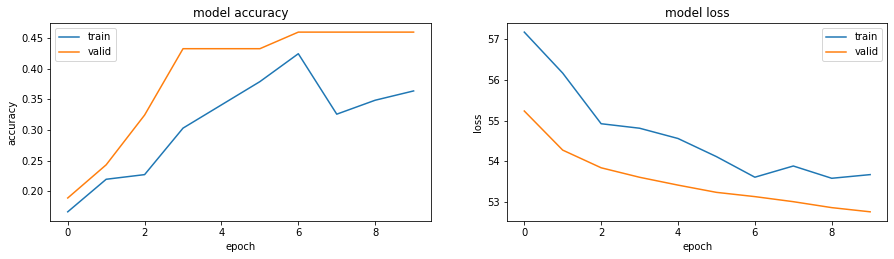


Hyperparameters: [[2.56e+02 1.00e-06 1.00e-03 2.00e+00 7.00e-01 3.20e+01 2.00e+00]]
2/2 [==============================] - 0s 8ms/step - loss: 2.5497 - accuracy: 0.4865

Epoch 1: val_accuracy improved from -inf to 0.13514, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.13514

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.13514

Epoch 4: val_accuracy did not improve from 0.13514
Epoch 4: early stopping
2/2 [==============================] - 0s 8ms/step - loss: 6.6796 - accuracy: 0.1351

LOSS:	6.679551124572754 	 ACCURACY:	0.13513512909412384
[6.679551124572754, 0.13513512909412384]



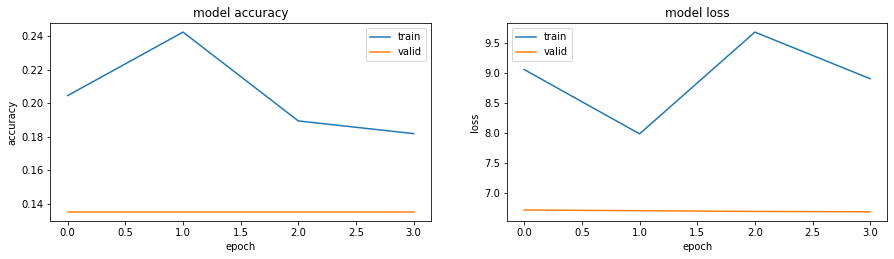




Hyperparameters: [[1.28e+02 1.00e-05 1.00e-01 1.00e+00 5.00e-01 1.28e+02 1.00e+00]]
2/2 [==============================] - 0s 8ms/step - loss: 2.5497 - accuracy: 0.4865

Epoch 1: val_accuracy improved from -inf to 0.43243, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.43243

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.43243

Epoch 4: val_accuracy did not improve from 0.43243
Epoch 4: early stopping
2/2 [==============================] - 0s 8ms/step - loss: 28.8458 - accuracy: 0.4324

LOSS:	28.84576988220215 	 ACCURACY:	0.4324324429035187
[28.84576988220215, 0.4324324429035187]



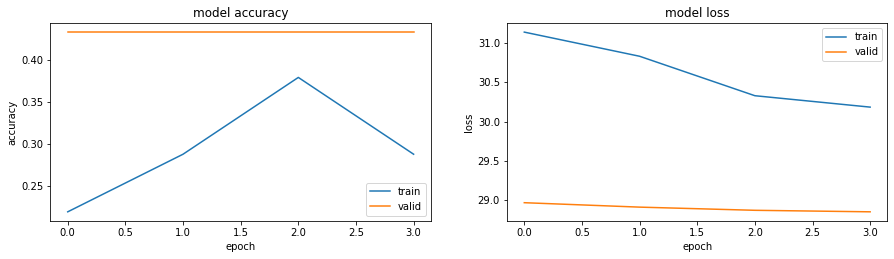


Hyperparameters: [[1.28e+02 1.00e-04 1.00e-01 2.00e+00 3.00e-01 1.28e+02 1.00e+00]]
2/2 [==============================] - 0s 9ms/step - loss: 2.5497 - accuracy: 0.4865

Epoch 1: val_accuracy improved from -inf to 0.35135, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.35135

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 3: val_accuracy did not improve from 0.35135

Epoch 4: val_accuracy did not improve from 0.35135
Epoch 4: early stopping
2/2 [==============================] - 0s 7ms/step - loss: 27.8468 - accuracy: 0.3243

LOSS:	27.846834182739258 	 ACCURACY:	0.3243243098258972
[27.846834182739258, 0.3243243098258972]



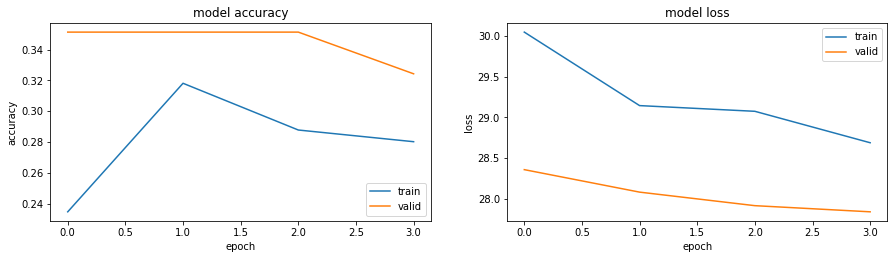


Hyperparameters: [[1.28e+02 1.00e-04 1.00e-01 1.00e+00 3.00e-01 2.56e+02 3.00e+00]]
2/2 [==============================] - 0s 9ms/step - loss: 2.5497 - accuracy: 0.4865

Epoch 1: val_accuracy improved from -inf to 0.43243, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.43243

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 3: val_accuracy did not improve from 0.43243

Epoch 4: val_accuracy did not improve from 0.43243
Epoch 4: early stopping
2/2 [==============================] - 0s 9ms/step - loss: 27.7042 - accuracy: 0.4054

LOSS:	27.704204559326172 	 ACCURACY:	0.4054054021835327
[27.704204559326172, 0.4054054021835327]



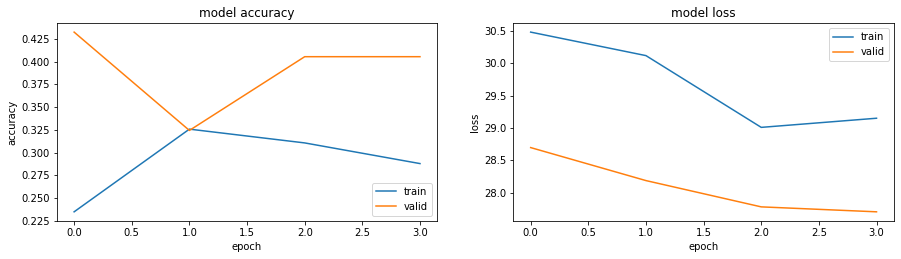


Hyperparameters: [[1.28e+02 1.00e-06 1.00e-02 3.00e+00 5.00e-01 2.56e+02 1.00e+00]]
2/2 [==============================] - 0s 8ms/step - loss: 2.5497 - accuracy: 0.4865

Epoch 1: val_accuracy improved from -inf to 0.21622, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.21622

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.21622

Epoch 4: val_accuracy did not improve from 0.21622
Epoch 4: early stopping
2/2 [==============================] - 0s 9ms/step - loss: 5.0410 - accuracy: 0.2162

LOSS:	5.041041374206543 	 ACCURACY:	0.21621622145175934
[5.041041374206543, 0.21621622145175934]



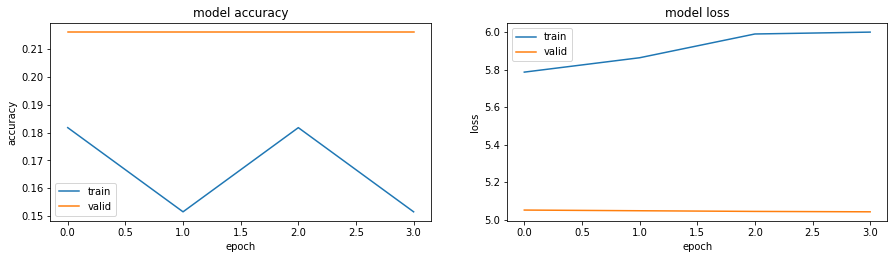


Hyperparameters: [[1.28e+02 1.00e-04 1.00e-03 1.00e+00 3.00e-01 3.20e+01 3.00e+00]]
2/2 [==============================] - 0s 10ms/step - loss: 2.5497 - accuracy: 0.4865

Epoch 1: val_accuracy improved from -inf to 0.21622, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.21622 to 0.45946, saving model to DR.h5

Epoch 3: val_accuracy did not improve from 0.45946

Epoch 4: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 4: val_accuracy did not improve from 0.45946

Epoch 5: val_accuracy did not improve from 0.45946
Epoch 5: early stopping
2/2 [==============================] - 0s 10ms/step - loss: 2.1339 - accuracy: 0.3784

LOSS:	2.1338553428649902 	 ACCURACY:	0.37837839126586914
[2.1338553428649902, 0.37837839126586914]



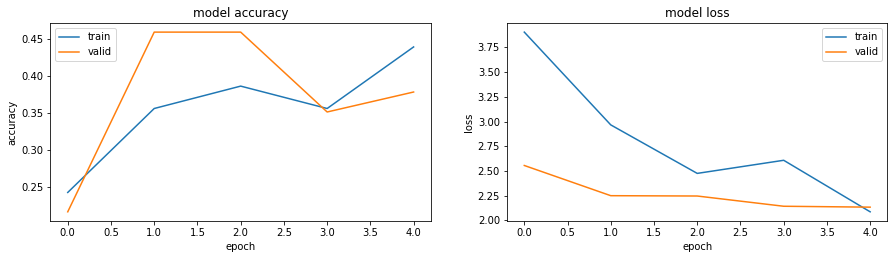


Hyperparameters: [[1.28e+02 1.00e-06 1.00e-03 1.00e+00 5.00e-01 1.28e+02 3.00e+00]]
2/2 [==============================] - 0s 9ms/step - loss: 2.5497 - accuracy: 0.4865

Epoch 1: val_accuracy improved from -inf to 0.08108, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.08108

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.08108

Epoch 4: val_accuracy did not improve from 0.08108
Epoch 4: early stopping
2/2 [==============================] - 0s 9ms/step - loss: 4.3739 - accuracy: 0.0811

LOSS:	4.373866081237793 	 ACCURACY:	0.0810810774564743
[4.373866081237793, 0.0810810774564743]



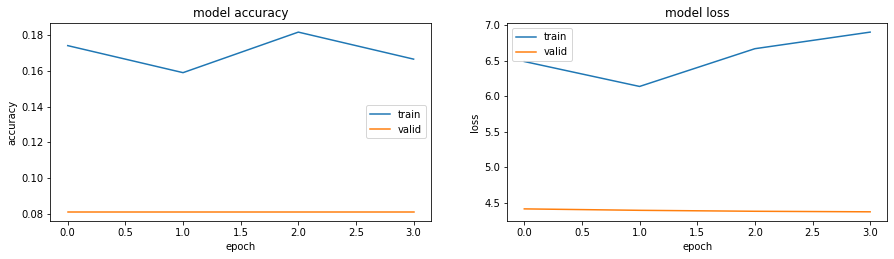


Hyperparameters: [[1.28e+02 1.00e-04 1.00e-02 2.00e+00 7.00e-01 2.56e+02 2.00e+00]]
2/2 [==============================] - 0s 6ms/step - loss: 2.5497 - accuracy: 0.4865

Epoch 1: val_accuracy improved from -inf to 0.43243, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.43243

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 3: val_accuracy did not improve from 0.43243

Epoch 4: val_accuracy did not improve from 0.43243
Epoch 4: early stopping
2/2 [==============================] - 0s 9ms/step - loss: 5.9713 - accuracy: 0.4324

LOSS:	5.971250534057617 	 ACCURACY:	0.4324324429035187
[5.971250534057617, 0.4324324429035187]



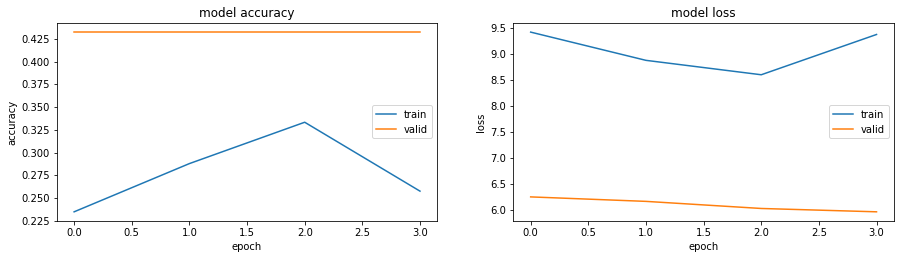


Hyperparameters: [[1.28e+02 1.00e-03 1.00e-01 1.00e+00 3.00e-01 3.20e+01 1.00e+00]]
2/2 [==============================] - 0s 10ms/step - loss: 2.5497 - accuracy: 0.4865

Epoch 1: val_accuracy improved from -inf to 0.18919, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.18919 to 0.56757, saving model to DR.h5

Epoch 3: val_accuracy did not improve from 0.56757

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 4: val_accuracy did not improve from 0.56757

Epoch 5: val_accuracy did not improve from 0.56757
Epoch 5: early stopping
2/2 [==============================] - 0s 12ms/step - loss: 14.1037 - accuracy: 0.5676

LOSS:	14.10374641418457 	 ACCURACY:	0.5675675868988037
[14.10374641418457, 0.5675675868988037]



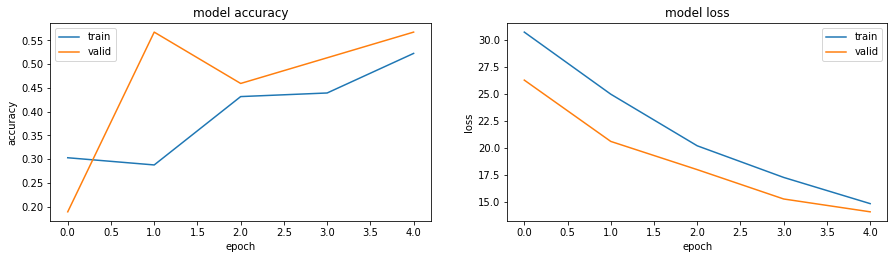


Hyperparameters: [[1.28e+02 1.00e-06 1.00e-01 1.00e+00 7.00e-01 3.20e+01 2.00e+00]]
2/2 [==============================] - 0s 11ms/step - loss: 14.1037 - accuracy: 0.5676

Epoch 1: val_accuracy improved from -inf to 0.21622, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.21622

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.21622

Epoch 4: val_accuracy did not improve from 0.21622
Epoch 4: early stopping
2/2 [==============================] - 0s 11ms/step - loss: 30.8898 - accuracy: 0.2162

LOSS:	30.889780044555664 	 ACCURACY:	0.21621622145175934
[30.889780044555664, 0.21621622145175934]



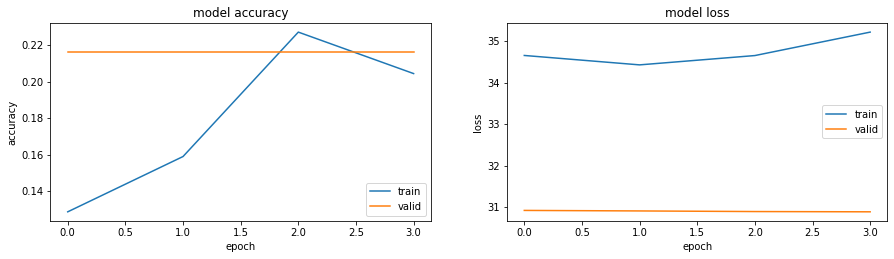


Hyperparameters: [[1.28e+02 1.00e-03 1.00e-03 1.00e+00 7.00e-01 3.20e+01 3.00e+00]]
2/2 [==============================] - 0s 12ms/step - loss: 14.1037 - accuracy: 0.5676

Epoch 1: val_accuracy improved from -inf to 0.35135, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.35135 to 0.62162, saving model to DR.h5

Epoch 3: val_accuracy did not improve from 0.62162

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 4: val_accuracy did not improve from 0.62162

Epoch 5: val_accuracy did not improve from 0.62162
Epoch 5: early stopping
2/2 [==============================] - 0s 11ms/step - loss: 1.4557 - accuracy: 0.4865

LOSS:	1.4556928873062134 	 ACCURACY:	0.4864864945411682
[1.4556928873062134, 0.4864864945411682]



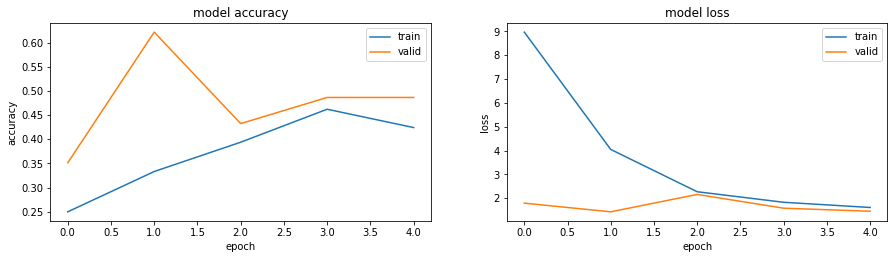


Hyperparameters: [[1.28e+02 1.00e-04 1.00e-03 2.00e+00 5.00e-01 2.56e+02 3.00e+00]]
2/2 [==============================] - 0s 7ms/step - loss: 14.1037 - accuracy: 0.5676

Epoch 1: val_accuracy improved from -inf to 0.40541, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.40541

Epoch 3: val_accuracy improved from 0.40541 to 0.43243, saving model to DR.h5

Epoch 4: val_accuracy did not improve from 0.43243

Epoch 5: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 5: val_accuracy did not improve from 0.43243

Epoch 6: val_accuracy did not improve from 0.43243
Epoch 6: early stopping
2/2 [==============================] - 0s 12ms/step - loss: 2.3341 - accuracy: 0.4324

LOSS:	2.3340587615966797 	 ACCURACY:	0.4324324429035187
[2.3340587615966797, 0.4324324429035187]



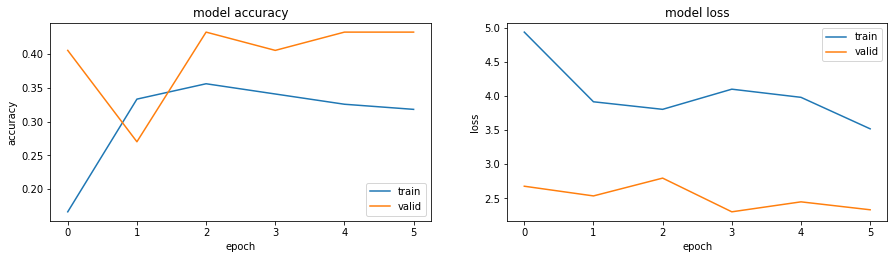


Hyperparameters: [[1.28e+02 1.00e-05 1.00e-03 2.00e+00 7.00e-01 2.56e+02 2.00e+00]]
2/2 [==============================] - 0s 8ms/step - loss: 14.1037 - accuracy: 0.5676

Epoch 1: val_accuracy improved from -inf to 0.16216, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.16216

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.16216

Epoch 4: val_accuracy did not improve from 0.16216
Epoch 4: early stopping
2/2 [==============================] - 0s 10ms/step - loss: 6.2050 - accuracy: 0.1622

LOSS:	6.2050461769104 	 ACCURACY:	0.1621621549129486
[6.2050461769104, 0.1621621549129486]



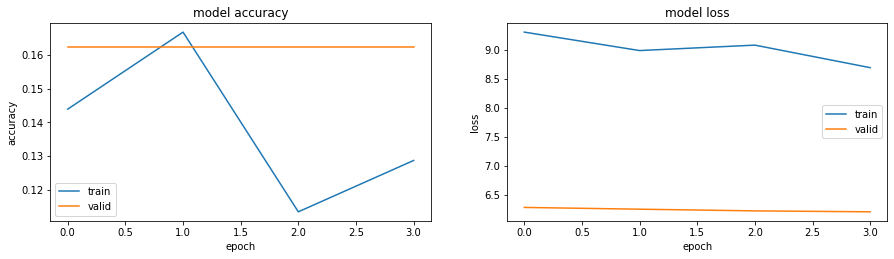


Hyperparameters: [[1.28e+02 1.00e-04 1.00e-01 3.00e+00 5.00e-01 2.56e+02 3.00e+00]]
2/2 [==============================] - 0s 12ms/step - loss: 14.1037 - accuracy: 0.5676

Epoch 1: val_accuracy improved from -inf to 0.27027, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.27027 to 0.32432, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.32432 to 0.43243, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.43243 to 0.45946, saving model to DR.h5

Epoch 5: val_accuracy did not improve from 0.45946

Epoch 6: val_accuracy improved from 0.45946 to 0.48649, saving model to DR.h5

Epoch 7: val_accuracy did not improve from 0.48649

Epoch 8: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 8: val_accuracy did not improve from 0.48649

Epoch 9: val_accuracy did not improve from 0.48649
Epoch 9: early stopping
2/2 [==============================] - 0s 15ms/step - loss: 26.4437 - accuracy: 0.4865

LOSS:	26.443675994873047 	 ACCURACY:	0.

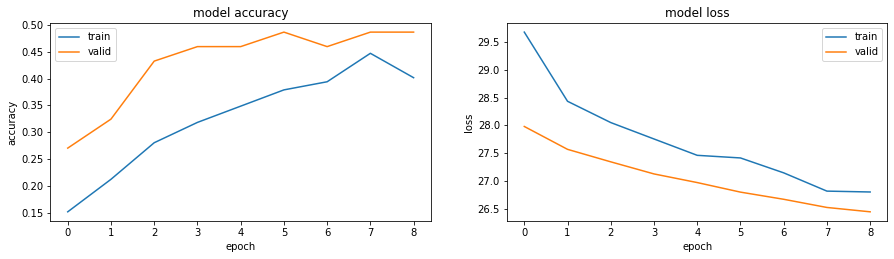


Hyperparameters: [[1.28e+02 1.00e-05 1.00e-03 2.00e+00 5.00e-01 2.56e+02 1.00e+00]]
2/2 [==============================] - 0s 13ms/step - loss: 14.1037 - accuracy: 0.5676


KeyboardInterrupt: ignored

In [ ]:
# define the kernel for the Bayesian surrogate model using the "radial basis function" (RBF)
kernel = GPy.kern.RBF(input_dim=1, variance=1.0, lengthscale=1.0)
# hyperparameter bounds
bounds = [{'name': 'units', 'type': 'discrete', 'domain': (64, 128, 256, 512)},
          {'name': 'learning_rate', 'type': 'discrete', 'domain': (1e-3, 1e-4, 1e-5, 1e-6)},
          {'name': 'l2', 'type': 'discrete', 'domain': (1e-1, 1e-2, 1e-3)},
          {'name': 'activation', 'type': 'discrete', 'domain': (1, 2, 3)},
          {'name': 'rate', 'type': 'discrete', 'domain': (0.3, 0.5, 0.7)},
          {'name': 'batch', 'type': 'discrete', 'domain': (32, 128, 256)},
          {'name': 'optim', 'type': 'discrete', 'domain': (1, 2, 3)}]
# Note: 'activation' domain parameters (1, 2, 3) correspond to strings ('relu', 'elu', 'tanh'); dictionary defined in build_model()
# Note: 'optim' domain parameters (1, 2, 3) correspond to strings ('Adam', 'SGD', 'RMSprop'); dictionary defined in build_model()
# objective function for the model optimization:
def f(x):
  """objective function of the Bayesian surrogate model"""
  print()
  print("Hyperparameters:", x)
  # Retrieve 'accuracy' from the previously saved model
  try:
    previous_best_model = K.models.load_model('DR_best.h5')
    previous_evaluation = evaluate_model(previous_best_model)
  except Exception:
    previous_best_model = None
  model, lr_reduce, early_stop, checkpoint, batch = build_model(
                                        units=int(x[:,0]),
                                        learning_rate=float(x[:,1]),
                                        l2=float(x[:,2]),
                                        activation=int(x[:,3]),
                                        rate=float(x[:,4]),
                                        batch=int(x[:,5]),
                                        optim=int(x[:,6]))
  history = fit_model(model, lr_reduce, early_stop, checkpoint, batch)
  evaluation = evaluate_model(model)
  print()
  print("LOSS:\t{0} \t ACCURACY:\t{1}".format(evaluation[0],evaluation[1]))
  #print("LOSS:\t{0} \t ACCURACY:\t{1} \t PRECISION:\t{2} \t RECALL:\t{3} \t F1-SCORE:\t{4}".format(evaluation[0], evaluation[1], evaluation[2], evaluation[3], evaluation[4]))
  print(evaluation)
  print()
  # compare previous and current validation accuracies
  if not previous_best_model:
    K.models.save_model(model, 'DR_best.h5', overwrite=False,
    include_optimizer=True)
  if previous_best_model and evaluation[1] > previous_evaluation[1]:
    K.models.save_model(model, 'DR_best.h5', overwrite=True,
    include_optimizer=True)
  # Get the dictionary containing each metric and the loss for each epoch
  # history_dict = history.history
  # print(history_dict)
  def plot_history(history):
  #function that plots the model loss and accuracy
    plt.figure(1, figsize = (15,8))
    plt.subplot(221)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'])
    plt.subplot(222)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'])
    plt.show()
  # plot the model accuracy and loss results
  plot_history(history)
  # delete the instantiated models from memory and clear the session
  del model
  del previous_best_model
  K.backend.clear_session()
  return evaluation[1]
# Initializing X and Y, and adding noise (if need be)
# X_init = np.array([[int(16)]])
# Y_init = f(X_init)
# noise = 0.2
optimizer = BayesianOptimization(f=f,
                                 domain=bounds,
                                 model_type='GP',
                                 kernel=kernel,
                                 acquisition_type ='EI',
                                 acquisition_jitter = 0.01,
                                 # X=X_init,
                                 # Y=-Y_init,
                                 # noise_var = noise**2,
                                 exact_feval=False,
                                 normalize_Y=False,
                                 maximize=True,
                                 verbosity=False)
print()
print("=====================")
print("=====================")
print()
optimizer.run_optimization(max_iter=100, verbosity=False)
optimizer.plot_acquisition()
optimizer.plot_convergence()
optimizer.save_report('bayes_opt.txt')

In [ ]:
# print optimized model
activation_dict = {1: 'relu', 2: 'elu', 3: 'tanh'}
optimizer_dict = {1: 'Adam', 2: 'SGD', 3: 'RMSprop'}
print("""
Optimized Parameters:
\t{0}:\t{1}
\t{2}:\t{3}
\t{4}:\t{5}
\t{6}:\t{7}
\t{8}:\t{9}
\t{10}:\t{11}
""".format(bounds[0]["name"], optimizer.x_opt[0],
           bounds[1]["name"], optimizer.x_opt[1],
           bounds[2]["name"], optimizer.x_opt[2],
           bounds[3]["name"], activation_dict[optimizer.x_opt[3]],
           bounds[4]["name"], optimizer.x_opt[4],
           bounds[5]["name"], optimizer.x_opt[5]),
           bounds[6]["name"], optimizer_dict[optimizer.x_opt[6]])
print("optimized accuracy: {0}".format(abs(optimizer.fx_opt)))


Optimized Parameters:
	units:	512.0
	learning_rate:	0.001
	l2:	0.1
	activation:	elu
	rate:	0.7
	batch:	128.0
 optim RMSprop
optimized accuracy: [0.]


In [ ]:
# reinstantiate the best model from saved file
best_model = K.models.load_model('DR_best.h5')
best_model.summary()
loss, acc = best_model.evaluate(features_valid, y_test) 
print('Restored model, accuracy: {:5.2f}%'.format(100*acc))

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1920)]            0         
                                                                 
 dense (Dense)               (None, 512)               983552    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 2565      
                                                                 
Total params: 986,117
Trainable params: 986,117
Non-trainable params: 0
_________________________________________________________________
37/37 [==============================] - 1s 8ms/step - loss: 1.4784 - accuracy: 0.0000e+00 - precision: 0.5458 - recall: 0.5458 - f1_score: 0.1412
Restored model, accuracy:  0.00%


In [ ]:
best_model.evaluate(features_valid, y_test)

37/37 [==============================] - 0s 7ms/step - loss: 1.4784 - accuracy: 0.0000e+00 - precision: 0.5458 - recall: 0.5458 - f1_score: 0.1412


[1.4783755540847778,
 0.0,
 0.5458477735519409,
 0.5458477735519409,
 0.14124231040477753]

In [ ]:
#print("LOSS:\t{0} \t ACCURACY:\t{1} \t PRECISION:\t{2} \t RECALL:\t{3} \t F1-SCORE:\t{4}".format(loss, acc, recall, precision, f1_score))

LOSS:	1.4783755540847778 	 ACCURACY:	0.0 	 PRECISION:	0.5458477735519409 	 RECALL:	0.5458477735519409 	 F1-SCORE:	0.14124231040477753


In [ ]:
data_path = 'bayes_opt.txt'
with open(data_path, 'r') as f:
  lines = f.read().split('\n')
for line in lines:
  print(line)

----------------------------- GPyOpt Report file -----------------------------------
GPyOpt Version 1.2.1
Date and time:               Mon May 30 10:19:27 2022
Optimization completed:      NO,105 samples collected.
Number initial samples:      5 
Tolerance:                   1e-08.
Optimization time:           947.2452249526978 seconds.

-------------------------------- Problem set up ------------------------------------
Problem name:                no_name
Problem dimension:           7
Number continuous variables  0
Number discrete variables    7
Number bandits               0
Noiseless evaluations:       False
Cost used:                   Used defined cost
Constrains:                  False

------------------------------ Optimization set up ---------------------------------
Normalized outputs:          False
Model type:                  GP
Model update interval:       1
Acquisition type:            EI
Acquisition optimizer:       lbfgs
Acquisition type:            EI
Acquisition op

Test model with test data

In [ ]:
#https://stackoverflow.com/questions/55674648/how-to-load-local-dataset-x-y-using-keras-framework
from image_dataset_loader import load

(x_train, y_train), (x_test, y_test) = load('/content/output/', ['train', 'test'])

In [ ]:
#  preprocess the data using the application's preprocess_input method and convert the labels to one-hot encodings
x_test, y_test = preprocess_data(x_test, y_test)

In [ ]:

# repeat the same operation with the test data (here used for test)
test_datagen = K.preprocessing.image.ImageDataGenerator()  # no augmentation for validation set
test_generator = test_datagen.flow(x_test,
                                 y_test,
                                 batch_size=32,
                                 shuffle=False)
features_test = base_model.predict(test_generator)

In [ ]:
# reinstantiate the best model from saved file
loss, acc = best_model.evaluate(features_test, y_test)
print('Restored model, accuracy: {:5.2f}%'.format(100*acc))

73/73 [==============================] - 0s 5ms/step - loss: 1.4733 - accuracy: 0.0000e+00 - precision: 0.5446 - recall: 0.5439 - f1_score: 0.1410
Restored model, accuracy:  0.00%


In [ ]:
best_model.evaluate(features_test, y_test)

73/73 [==============================] - 0s 5ms/step - loss: 1.4733 - accuracy: 0.0000e+00 - precision: 0.5446 - recall: 0.5439 - f1_score: 0.1410


[1.4733130931854248,
 0.0,
 0.54463130235672,
 0.5439276695251465,
 0.14103852212429047]

In [ ]:
#print("LOSS:\t{0} \t ACCURACY:\t{1} \t PRECISION:\t{2} \t RECALL:\t{3} \t F1-SCORE:\t{4}".format(loss, acc, recall, precision, f1_score))

LOSS:	1.4733130931854248 	 ACCURACY:	0.0 	 PRECISION:	0.54463130235672 	 RECALL:	0.5439276695251465 	 F1-SCORE:	0.14103852212429047
